In [1]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
# import wrf

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature


# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from plotter import draw_basemap

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
fname = '../out/baja_IVT_composite.nc'
ds = xr.open_dataset(fname)
ds = ds.sel(lat=slice(15., 50.), lon=slice(-180., -80.))
ds

ds_lst = [ds]

In [4]:
# Set up projection
# mapcrs = ccrs.Mercator()
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
lats = ds.lat.values
lons = ds.lon.values
dx = np.arange(lons.min().round(),lons.max().round()+20,20)
dy = np.arange(lats.min().round()+1,lats.max().round()+10,10)

ext = [-140., -80., 20, 50]

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

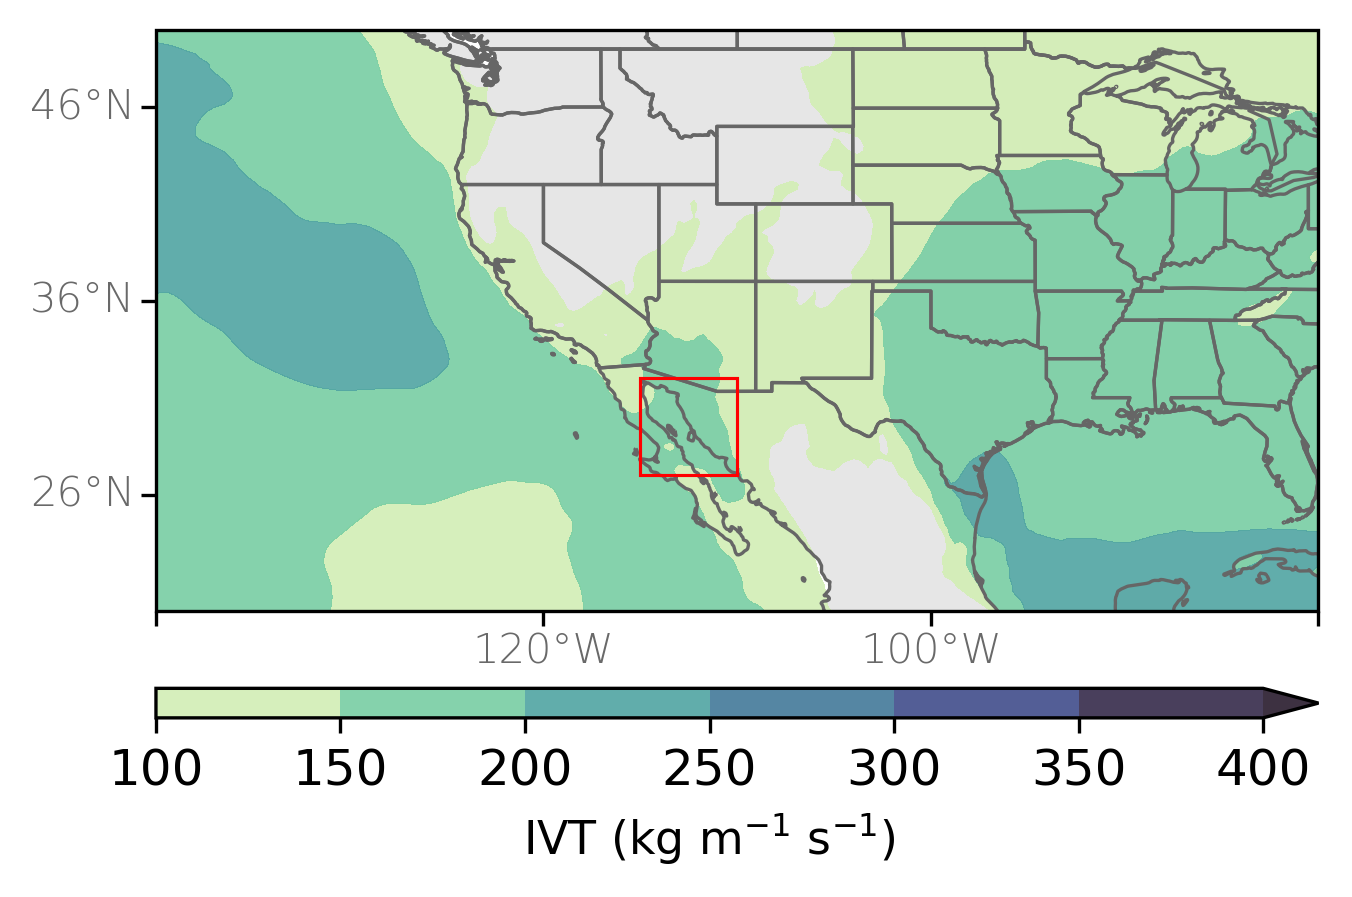

In [7]:
# Create figure
fig = plt.figure(figsize=(5, 3))
fig.dpi = 300
fname = path_to_figs + 'baja_IVT_composite'
fmt = 'png'

# contour labels
kw_clabels = {'fontsize': 7, 'inline': True, 'inline_spacing': 7, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}

nrows = 3
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 0.05, 0.05], width_ratios = [1], wspace=0.01, hspace=0.1)
## use gs[rows index, columns index] to access grids

#####################
### IVT COMPOSITE ###
#####################

for i, ds in enumerate(ds_lst):
    ax = fig.add_subplot(gs[0, 0], projection=mapcrs)
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False, bottom_lons=True)
    ax.add_feature(cfeature.STATES, edgecolor='0.4', linewidth=0.8)
    # Contour Filled
    lats = ds.lat.values
    lons = ds.lon.values
    ivt = ds.IVT.values
    cflevs = np.arange(100, 450, 50) # levels for IVT
    cmap = cmo.deep # cmap for IVT
    cf = ax.contourf(lons, lats, ivt, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

    # # Wind barbs / vectors 
    # uvec = ds.IVTu.values
    # vvec = ds.IVTv.values
    # uvec_mask = ds.IVTu.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1
    # vvec_mask = ds.IVTv.where((ds.IVT >=250.)).values # mask values where IVT magnitude is less than 250 kg m-1 s-1

    # Q = ax.quiver(lons, lats, uvec_mask, vvec_mask, transform=datacrs, 
    #           color='k', regrid_shape=20,
    #           angles='xy', scale_units='xy', scale=125, units='xy')

    # # Contour Lines
    # hgts = ds.z.values/(100) # convert to dekameters # 250-hPa Heights
    # clevs = np.arange(696, 1280, 12)
    # cs = ax.contour(lons, lats, hgts, transform=datacrs,
    #                 levels=clevs, colors='grey', linewidths=0.7)
    # plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

    # # Plot MSLP
    # clevs_slp = np.arange(800., 1120., 4)
    # slp_smooth = gaussian_filter(ds.msl.values/100., sigma=4)
    # cs2 = ax.contour(lons, lats, slp_smooth, transform=datacrs,
    #                  levels=clevs_slp, colors='k',
    #                  linewidths=1., linestyles='solid')
    # plt.clabel(cs2, **kw_clabels)

    # # quiver key
    # qk = ax.quiverkey(Q, 0.01, -0.025, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
    #                   coordinates='axes', fontproperties={'size': 6.0})

    ext3 = [-115., -110., 27., 32.]
    ax.add_patch(mpatches.Rectangle(xy=[ext3[0], ext3[2]], width=ext3[1]-ext3[0], height=ext3[3]-ext3[2],
                                        fill=False,
                                        edgecolor='r',
                                        linewidth=0.75,
                                        transform=datacrs,
                                        zorder=199))
# Colorbar (single)
cbax = plt.subplot(gs[-1,:]) # colorbar axis
cb = fig.colorbar(cf, cbax, orientation='horizontal', drawedges=False)
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)
cb.ax.tick_params(labelsize=12)

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()